In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.1, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [9]:
x_train.shape

(500, 160, 10, 1)

In [10]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [12]:
latent_dim = 10
epsilon_std = 1.0
batch_size = 128
epochs = 500

name = 'non-functional_model.h5'
fn = config.model_dir + name

In [13]:
vae, encoder, generator = models.build(input_shape, latent_dim)
vae.load_weights(fn)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


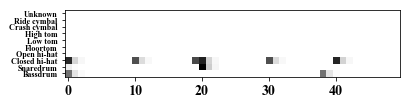

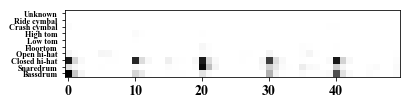

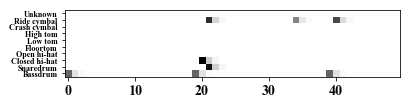

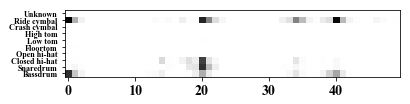

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [14]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

## Style transfer

In [15]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [16]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)

In [17]:
list(transformations.keys())[:]

['02 Blues/02 Nappy Brown 160BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '04 Country/07 Trainy 100BPM',
 '06 Soul - Funk/02 Boogaloo 120BPM',
 '06 Soul - Funk/04 GoGo Soul 100BPM',
 '07 Indie/01 Rock Shuffle 130BPM',
 "01 Rock'n'Roll/02 Gogo 191BPM",
 '02 Blues/09 Leroyes 130BPM',
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 '05 Jazz/05 TNT 116BPM',
 '03 Traditional Pop/05 Your Eyes 80BPM',
 '05 Jazz/07 Kooper 234BPM',
 '03 Traditional Pop/09 Distel 155BPM',
 '06 Soul - Funk/07 Ride Swing 95Bpm',
 '05 Jazz/10 Scalis 190BPM 3-4',
 "01 Rock'n'Roll/07 Thwag 170BPM",
 '07 Indie/03 Moon 137BPM',
 '05 Jazz/06 Nucleus 172BPM Brushes',
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 '05 Jazz/03 Cool 137BPM Brushes',
 '03 Traditional Pop/02 Frankies Girl 116BPM',
 '07 Indie/05 Halftime 71BPM',
 '07 Indie/04 Titanic 97BPM',
 '04 Country/02 Marching 94BPM',
 '03 Traditional Pop/07 Lester Lee 133BPM',
 '03 Traditional Pop/03 King Quiza 102BPM',
 '05 Jazz/09 West Coast 152BPM Brushes',
 '06 Soul - Funk/03 C

In [18]:
len(transformations.keys())

65

In [19]:
utils.reload(ncd_evaluation)
grid = [0, 0.01, 0.1, 0.5, 1]
db, x_result, meta = ncd_evaluation.transform(x_train_encoded, genre_dict, min_transformations, 
                generator, grid, amt1=3, v=1)

02 Blues/02 Nappy Brown 160BPM 	-> 07 Indie/05 Halftime 71BPM
03 Traditional Pop/04 Love 155BPM 	-> 01 Rock'n'Roll/05 Straight Line 136BPM
04 Country/07 Trainy 100BPM 	-> 02 Blues/04 Mickeys 212BPM 12-8


In [20]:
x_result.shape

(15, 7, 160, 10, 1)

['02 Blues/02 Nappy Brown 160BPM', '07 Indie/05 Halftime 71BPM']


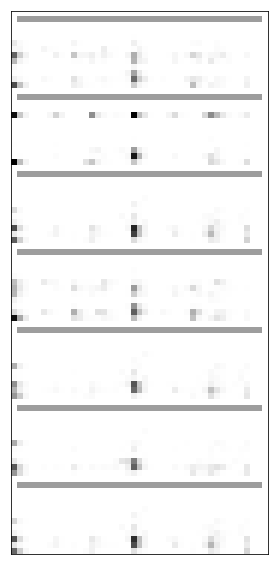

In [21]:
_,keys,i = utils.get(db, recursion_depth=1, i=0)
# print(db)
print(keys)
# # plot.single(x_result[0,0,:30])
plot.multi(x_result[i])

In [22]:
# utils.reload(midi, midi.decode)
def save_x_grid_search(x, i, grid):
    """x :: (samples, grid) + (midi.MultiTrack)
    """
    name = 'incr-transform'
    for grid_i, v in enumerate(grid):
        fn = config.export_dir + name + ('{id-%i-%i-%s}'%(i,grid_i,str(round(v,2))))
        print(fn)
        mid = midi.decode.track(context, x[i,grid_i])
        io.export_midifile(mid, fn)

In [24]:
i

0

In [25]:
save_x_grid_search(x_result, i, grid)
save_x_grid_search(x_result, 2, grid)
save_x_grid_search(x_result, 3, grid)

../midis/incr-transform{id-0-0-0}
 [INFO] : 
 |  len, max_t
 |  3.6
 |  4.0
../midis/incr-transform{id-0-1-0.01}
 [INFO] : 
 |  len, max_t
 |  3.925000000000002
 |  4.0
../midis/incr-transform{id-0-2-0.1}
 [INFO] : 
 |  len, max_t
 |  3.6000000000000005
 |  4.0
../midis/incr-transform{id-0-3-0.5}
 [INFO] : 
 |  len, max_t
 |  3.85
 |  4.0
../midis/incr-transform{id-0-4-1}
 [INFO] : 
 |  len, max_t
 |  3.6000000000000005
 |  4.0
../midis/incr-transform{id-2-0-0}
 [INFO] : 
 |  len, max_t
 |  3.6
 |  4.0
../midis/incr-transform{id-2-1-0.01}
 [INFO] : 
 |  len, max_t
 |  3.925000000000002
 |  4.0
../midis/incr-transform{id-2-2-0.1}
 [INFO] : 
 |  len, max_t
 |  3.6000000000000005
 |  4.0
../midis/incr-transform{id-2-3-0.5}
 [INFO] : 
 |  len, max_t
 |  3.85
 |  4.0
../midis/incr-transform{id-2-4-1}
 [INFO] : 
 |  len, max_t
 |  3.6000000000000005
 |  4.0
../midis/incr-transform{id-3-0-0}
 [INFO] : 
 |  len, max_t
 |  3.6
 |  4.0
../midis/incr-transform{id-3-1-0.01}
 [INFO] : 
 |  len, max

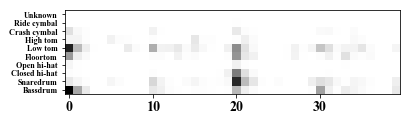

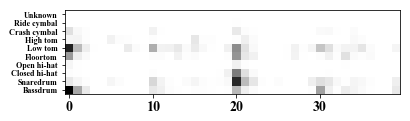

In [39]:
indices = [0,1,2]
plot.single(x_result[0,0,:40])
plot.single(x_result[2,0,:40]);